In [21]:
import torch
import dataloader
import baseline
import vae
import evaluation

import importlib
import matplotlib.pyplot as plt

In [22]:
importlib.reload(dataloader)
from dataloader import GraphDataLoader

gdl = GraphDataLoader("MUTAG", device="cpu", seed=0, batch_size=(144, 44, 0))

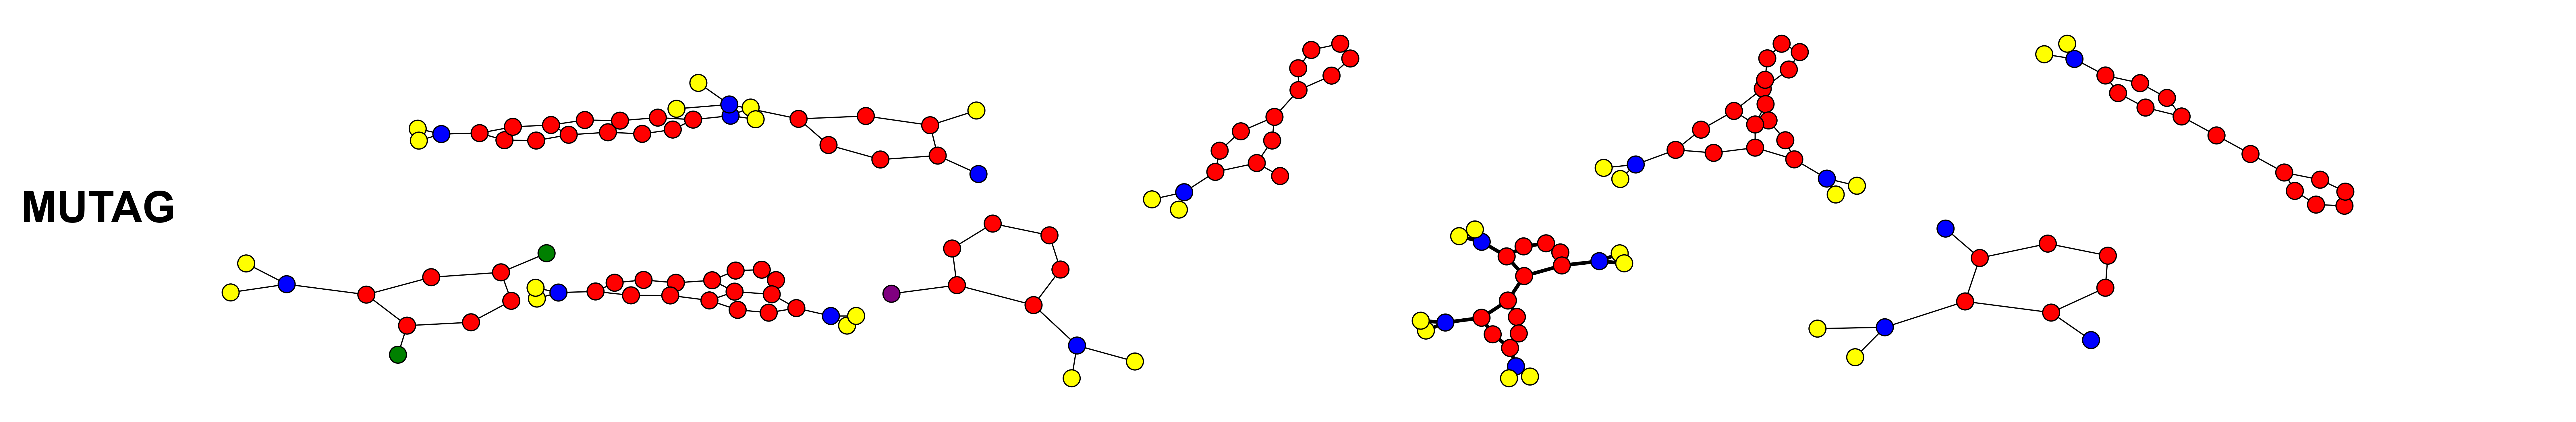

In [23]:
gdl.plot_graphs(
    gdl.train_loader.dataset,
    num_graphs=10,
    title="MUTAG        ",
    seed=0,
    figsize=(30, 5),
)
plt.savefig("MUTAG.pdf")

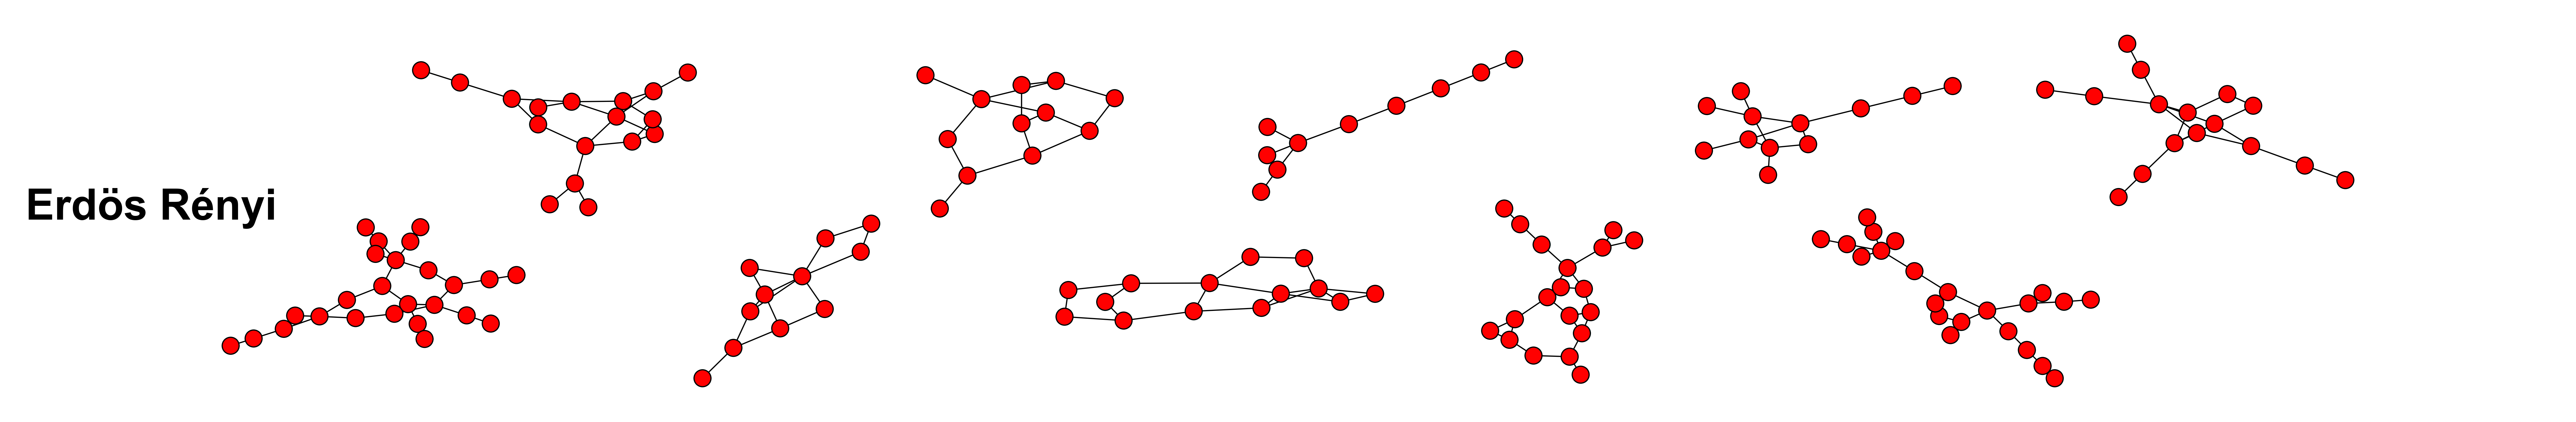

In [24]:
importlib.reload(baseline)
from baseline import ErdosRenyi

baseline_model = ErdosRenyi(gdl)
baseline_samples = baseline_model.sample(1000, seed=0)
gdl.plot_graphs_from_adjacency_matrix(
    baseline_samples, num_graphs=10, title="Erdös Rényi", figsize=(30, 5)
)
plt.savefig("ErdosRenyi.pdf")

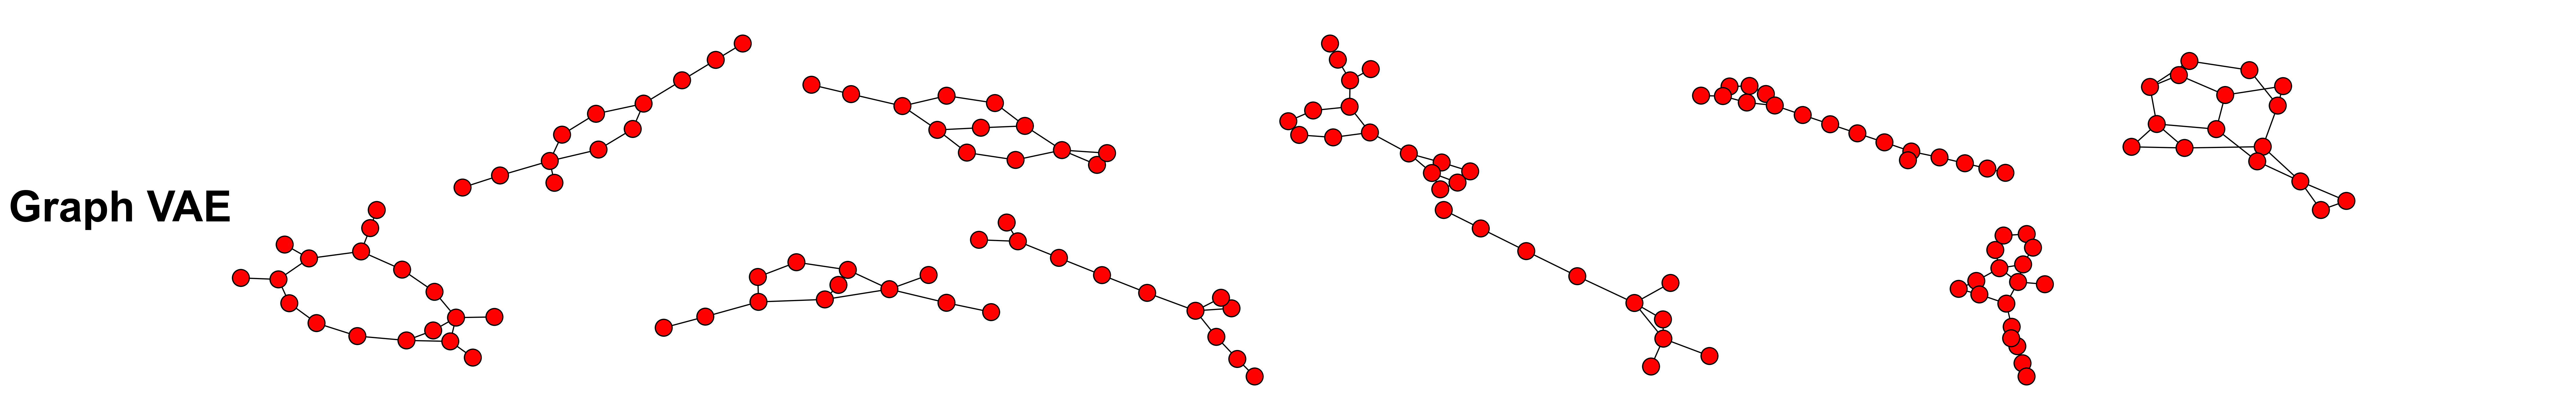

In [25]:
importlib.reload(vae)
from vae import GraphLevelVAE

model = GraphLevelVAE()
chekpoint = torch.load("model.pth")
model.load_state_dict(chekpoint)
model.to("cpu")
model.eval()

torch.manual_seed(112254)
samples = model.sample(1000)
# set seed
gdl.plot_graphs_from_adjacency_matrix(
    samples, num_graphs=10, title="Graph VAE ", figsize=(30, 5)
)

plt.savefig("vae_samples.pdf")

In [26]:
importlib.reload(evaluation)
from evaluation import Evaluator

evaluator = Evaluator(gdl)
print("Erdös Rényi:")
novelty, uniqueness, novelty_and_uniqueness = evaluator.evaluate(baseline_samples)
print(f"\tNovelty:\t\t {novelty:.4f}")
print(f"\tUniqueness:\t\t {uniqueness:.4f}")
print(f"\tNovelty and Uniqueness:\t {novelty_and_uniqueness:.4f}")

print("graph VAE:")
novelty, uniqueness, novelty_and_uniqueness = evaluator.evaluate(samples)
print(f"\tNovelty:\t\t {novelty:.4f}")
print(f"\tUniqueness:\t\t {uniqueness:.4f}")
print(f"\tNovelty and Uniqueness:\t {novelty_and_uniqueness:.4f}")

Erdös Rényi:
	Novelty:		 1.0000
	Uniqueness:		 0.9750
	Novelty and Uniqueness:	 0.9750
graph VAE:
	Novelty:		 1.0000
	Uniqueness:		 0.9340
	Novelty and Uniqueness:	 0.9340


In [27]:
importlib.reload(evaluation)
from evaluation import Evaluator

evaluator = Evaluator(gdl)
node_degrees = {
    "Emperical": evaluator.node_degrees(),
    "Baseline": evaluator.node_degrees(baseline_samples),
    "Graph VAE": evaluator.node_degrees(samples),
}
clustering_coef = {
    "Emperical": evaluator.clustering_coefficients(),
    "Baseline": evaluator.clustering_coefficients(baseline_samples),
    "Graph VAE": evaluator.clustering_coefficients(samples),
}
eigenvect_cen = {
    "Emperical": evaluator.eigenvector_centralities(),
    "Baseline": evaluator.eigenvector_centralities(baseline_samples),
    "Graph VAE": evaluator.eigenvector_centralities(samples),
}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")


def plot_distribution(df, title):
    # Plotting
    plt.figure(figsize=(16, 3))
    sns.barplot(x="metric", y="Density", hue="Model", data=df, capsize=0.1)
    # plt.title("Node Degree Distribution")
    plt.xlabel(title, fontsize=20)
    plt.ylabel("Density", fontsize=20)
    plt.legend(loc="upper right", fontsize=20)
    plt.ylim(0, 0.5)
    # set tick labels font size
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()

/Users/joergensen/opt/anaconda3/envs/DeepLearning/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joergensen/opt/anaconda3/envs/DeepLearning/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joergensen/opt/anaconda3/envs/DeepLearning/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/joergensen/opt/anaconda3/envs/DeepLearning/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_d

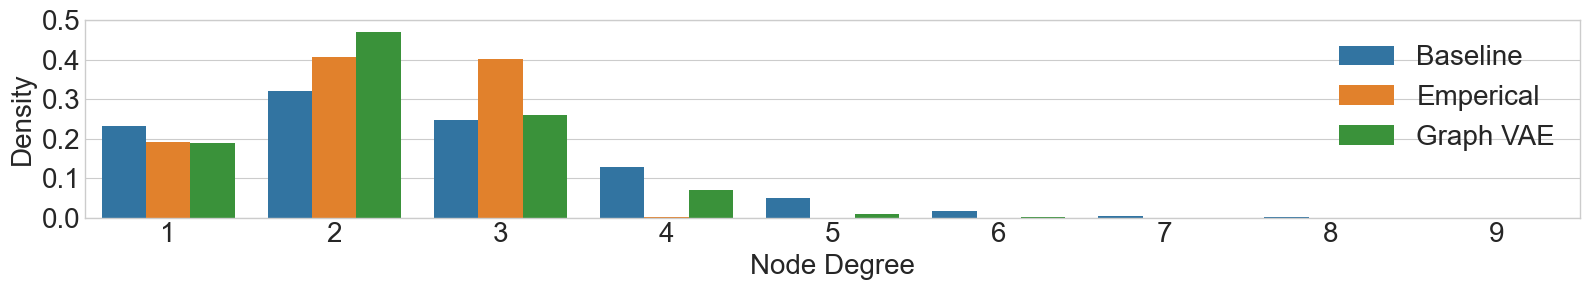

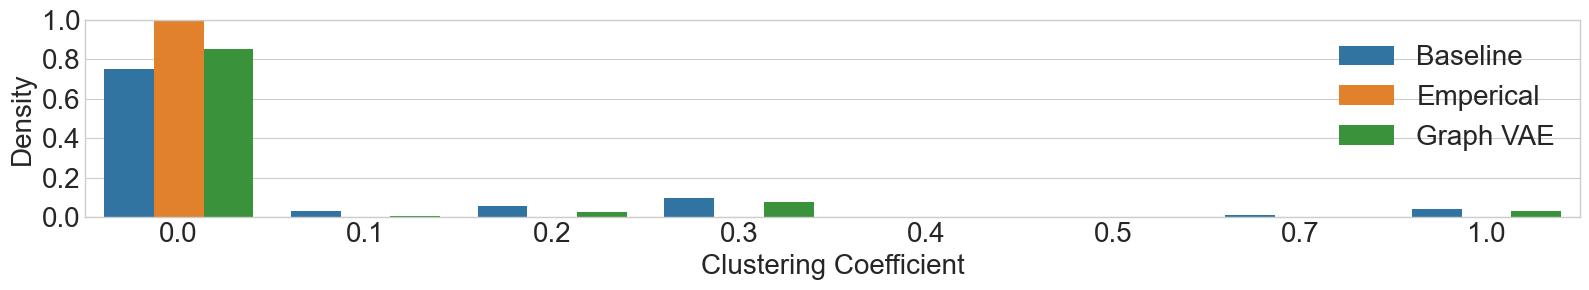

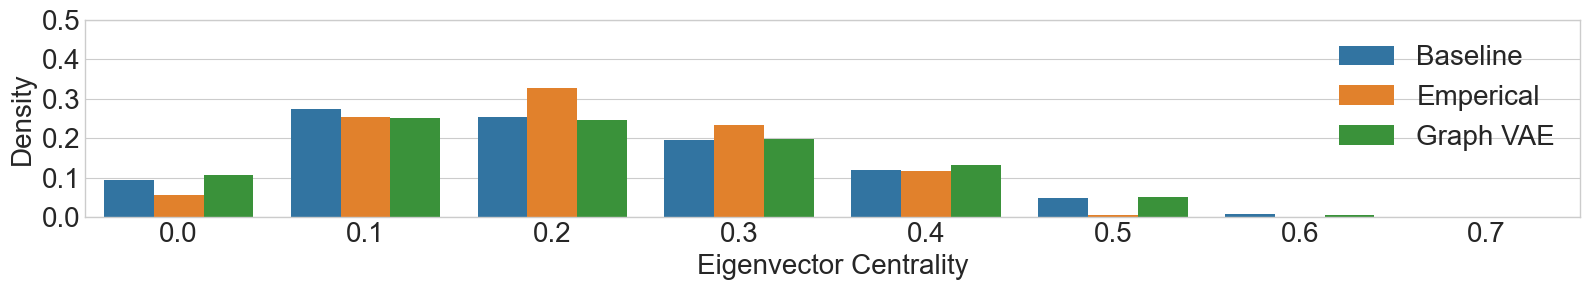

In [ ]:
data_list = []
for label, degrees in node_degrees.items():
    for degree in degrees:
        data_list.append({"Model": label, "metric": degree})
df = pd.DataFrame(data_list)
df_summary = df.groupby(["Model", "metric"]).size().reset_index(name="Counts")
df_summary["Density"] = df_summary["Counts"] / df_summary.groupby(["Model"])[
    "Counts"
].transform("sum")
plot_distribution(df_summary, "Node Degree")
plt.savefig("node_degree_distribution.pdf")


data_list = []
for label, degrees in clustering_coef.items():
    for degree in degrees:
        data_list.append({"Model": label, "Clustering_Coef": degree})
df = pd.DataFrame(data_list)
df["metric"] = df["Clustering_Coef"].apply(lambda x: round(x, 1))
# Grouping data by 'Model' and 'Degree' and calculating mean and SEM
df_summary = df.groupby(["Model", "metric"]).size().reset_index(name="Counts")
# # divide with the total count within each group
df_summary["Density"] = df_summary["Counts"] / df_summary.groupby(["Model"])[
    "Counts"
].transform("sum")
plot_distribution(df_summary, "Clustering Coefficient")
plt.ylim(0, 1)
plt.savefig("clustering_coefficient_distribution.pdf")


data_list = []
for label, degrees in eigenvect_cen.items():
    for degree in degrees:
        data_list.append({"Model": label, "Eigenvector_Centrality": degree})
df = pd.DataFrame(data_list)
df["metric"] = df["Eigenvector_Centrality"].apply(lambda x: round(x, 1))
df_summary = df.groupby(["Model", "metric"]).size().reset_index(name="Counts")
df_summary["Density"] = df_summary["Counts"] / df_summary.groupby(["Model"])[
    "Counts"
].transform("sum")
plot_distribution(df_summary, "Eigenvector Centrality")
plt.savefig("eigenvector_centrality_distribution.pdf")